<a href="https://colab.research.google.com/github/lxndrshm/DLFS_NLP_Onion_ML/blob/main/code/Project_Notebook_final_alex_max_peyman_v1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fake News Headline Detection**

**Introduction**

Overview on what is "The Onion"
and Overview on Subreddit "Nottheonion"

Link to quiz: https://forms.gle/jrugfy4WUVjf5oSq5

## **Overview of the dataset**

Link to the dataset: https://raw.githubusercontent.com/lukefeilberg/onion/master/OnionOrNot.csv

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/lukefeilberg/onion/master/OnionOrNot.csv")

In [ ]:
df

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1
...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1
23996,Connecticut TV station under fire after using ...,0
23997,Jurisprudence Fetishist Gets Off On Technicality,1
23998,Employees From Other Department Announce Plan ...,1


In [ ]:
print((df.label == 1).sum()) #Onion articles
print((df.label == 0).sum()) #NotTheOnion articles, real, but "onion-like" articles

9000
15000


In [ ]:
# Create dataset with 10 examples that the class will predict and delete them from the original 
# dataset to predict them later on with the created model
df_ten = df.iloc[[7, 2481, 17469, 17472, 17731, 17853, 17369, 17422, 17245, 19726]] 
df = df.drop([7, 2481, 17469, 17472, 17731, 17853, 17369, 17422, 17245, 19726]) 

## **Preprocessing of the data**

remove punctuation and stopwords

Lemmatization

Tokenize + Padding


In [ ]:
#Functions for removing punctuation and stopwords and apply lemmatization
import string
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Function to remove all of the following characters: !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
# Example:
# "I live in a nice town. I like it here!"
# ---------
# "I live in a nice town I like it here"
def remove_punctuation(text):
  translator = str.maketrans("", "", string.punctuation)
  return text.translate(translator)

# Function to remove stopwords defined in a set, like "a", "and", "but" etc.
# Example:
# "I live in an nice town I like it here"
# ---------
# "live nice town like"
stop = {"a"}
stop = set(stopwords.words("english"))
def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

# Function to lemmatize the dataset
# Example:
# geese -> goose
# "live nice towns like"
# ------
# "live nice town like"
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text.split()]
  return " ".join(lemm_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["text"] = df.text.map(remove_punctuation)
df["text"] = df.text.map(remove_stopwords)
df["text"] = df.text.map(lemmatizer)

In [ ]:
from collections import Counter

# Count unique words in the dataset
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df.text)
num_unique_words = len(counter)
len(counter)

26811

In [ ]:
# Split dataset into training and validation set

# shuffling the data beforehand
df = df.sample(frac=1)

train_size = int(df.shape[0] * 0.85)

train_df = df[:train_size]
val_df = df[train_size:]

print("Train label 1: ", (train_df.label == 1).sum()) #Onion articles
print("Train label 0: ", (train_df.label == 0).sum()) #NotTheOnion articles, real, but "onion-like" articles

print("Val label 1: ", (val_df.label == 1).sum()) #Onion articles
print("Val label 0: ", (val_df.label == 0).sum()) #NotTheOnion articles, real, but "onion-like" articles

# split text and labels
train_sentences = train_df.text.to_numpy()
train_labels = train_df.label.to_numpy()
val_sentences = val_df.text.to_numpy()
val_labels = val_df.label.to_numpy()

train_sentences.shape, val_sentences.shape

Train label 1:  7709
Train label 0:  12682
Val label 1:  1287
Val label 0:  2312


((20391,), (3599,))

In [ ]:
# Tokenize the sentences in the dataset
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

# each word has unique index
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [ ]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [ ]:
print(train_sentences[0])
print(train_sequences[0])
print(train_padded[0])

brilliant innovator elon musk announced currently developing lemon leg sprint hungry people world
[4574, 12319, 1176, 1095, 431, 1709, 2010, 4575, 673, 6005, 2262, 12, 41]
[ 4574 12319  1176  1095   431  1709  2010  4575   673  6005  2262    12
    41     0     0     0     0     0     0     0]


## **Our own model**

LSTM



In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard


In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [ ]:
import numpy as np
neg, pos = np.bincount(df['label'])
bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(bias)

print(bias)

[-0.51087009]


In [ ]:
# Create a model.
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding((len(word_index)-1), 16, input_length=max_length),
        #tf.keras.layers.LSTM(5, return_sequences=True),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(10, return_sequences=True),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(10),
        tf.keras.layers.Dropout(0.4),
        #tf.keras.layers.Dense(8, activation="relu"),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 16)            395936    
                                                                 
 lstm_4 (LSTM)               (None, 20, 10)            1080      
                                                                 
 dropout_4 (Dropout)         (None, 20, 10)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
from tensorflow import keras

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels), callbacks=[callback])

Epoch 1/10
638/638 [==============================] - 8s 9ms/step - loss: 0.6629 - accuracy: 0.6219 - val_loss: 0.6514 - val_accuracy: 0.6424
Epoch 2/10
638/638 [==============================] - 5s 8ms/step - loss: 0.5155 - accuracy: 0.7330 - val_loss: 0.4169 - val_accuracy: 0.8180
Epoch 3/10
638/638 [==============================] - 5s 8ms/step - loss: 0.3200 - accuracy: 0.8803 - val_loss: 0.3993 - val_accuracy: 0.8294
Epoch 4/10
638/638 [==============================] - 5s 8ms/step - loss: 0.2446 - accuracy: 0.9195 - val_loss: 0.4124 - val_accuracy: 0.8316


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6776469752192498)

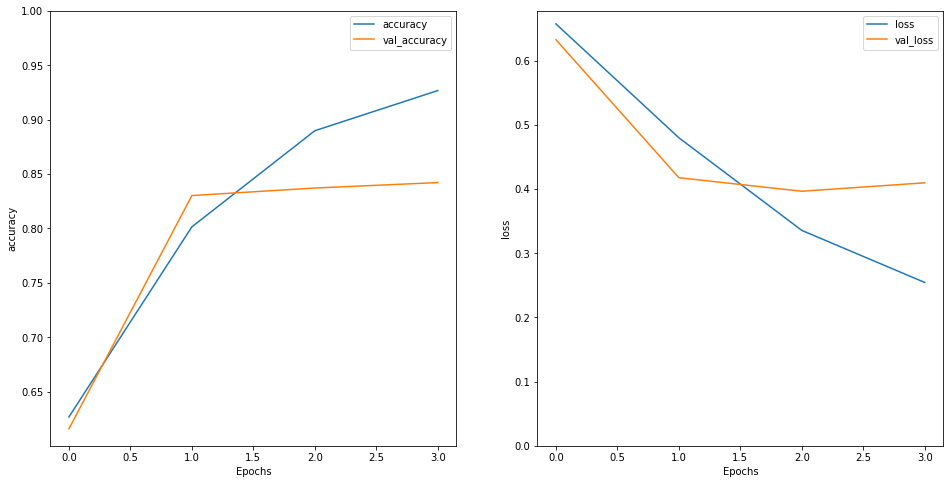

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## **Transfer Learning Models**

BERT

In [ ]:
!pip install datasets transformers[sentencepiece]

     |████████████████████████████████| 306 kB 7.6 MB/s 
     |████████████████████████████████| 3.4 MB 65.1 MB/s 
     |████████████████████████████████| 1.1 MB 65.1 MB/s 
     |████████████████████████████████| 67 kB 1.3 MB/s 
     |████████████████████████████████| 243 kB 70.0 MB/s 
     |████████████████████████████████| 133 kB 73.1 MB/s 
     |████████████████████████████████| 192 kB 72.0 MB/s 
     |████████████████████████████████| 160 kB 76.9 MB/s 
     |████████████████████████████████| 271 kB 74.0 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 3.3 MB 58.4 MB/s 
     |████████████████████████████████| 895 kB 70.7 MB/s 
     |████████████████████████████████| 1.2 MB 58.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
rom datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np
from datasets import load_dataset

# Data set should uploaded into google drive
dataset = load_dataset('csv', data_files='OnionOrNot.csv')

raw_datasets = dataset

# With change of check point to another Transformer the model can model with differnt transformer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#Tokenizer for BERT
#tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)


Using custom data configuration default-9193b77c14664cba
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-9193b77c14664cba/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-9193b77c14664cba/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-527101064d8361b3.arrow


# define the model

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- compile the model 
for define optimizer, loss function and metrics

- fit the model for show how model generalizes a similar data with data set

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
)

 325/3000 [==>...........................] - ETA: 2:16 - loss: 0.7063 - accuracy: 0.5885

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 8
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
num_train_steps = len(tf_train_dataset) * num_epochs

# useing the learning rate scheduler for decrease the initial learning rate
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

reloading the model, to reset the changes to the weights from the training run we just did, and then we can compile it with the new optimizer:

In [ ]:
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



fit the model again regarding new configurations

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Epoch 1/3
  47/3000 [..............................] - ETA: 2:39 - loss: 0.7314 - accuracy: 0.6995

KeyboardInterrupt: ignored

 Passing string of "logit" as softmax in Keras

Note a very common pitfall here — you can just pass the name of the loss as a string to Keras, but by default Keras will assume that you have already applied a softmax to your outputs. Many models, however, output the values right before the softmax is applied, which are also known as the logits. We need to tell the loss function that that’s what our model does, and the only way to do that is to call it directly, rather than by name with a string.

 startinh point of transformer models:

 From long experience, though, we know that transformer models benefit from a much lower learning rate than the default for Adam, which is 1e-3, also written as 10 to the power of -3, or 0.001. 5e-5 (0.00005), which is some twenty times lower, is a much better starting point.

source: https://huggingface.co/course/chapter3/3?fw=tf



**for getting outputs from the trained model, either to compute some metrics, or to use the model in production we can use the predict**

In [ ]:
preds = model.predict(tf_validation_dataset)["logits"]

Converting softmax [logit] into models class prediction

In [ ]:
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

(24000, 2) (24000,)


compute the model's performance

In [ ]:
from datasets import load_metric

# The F1 score is the harmonic mean of the precision and recall. It can be computed with: F1 = 2 * (precision * recall) / (precision + recall)
# metric = load_metric("f1")

# the General Language Understanding Evaluation benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems.
# metric = load_metric("glue", "mrpc")

#Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with: 
# Accuracy = (TP + TN) / (TP + TN + FP + FN) TP: True positive TN: True negative FP: False positive FN: False negative
metric = load_metric("accuracy")

metric.compute(predictions=class_preds, references=raw_datasets["train"]["label"])

{'accuracy': 0.99875}

## **Results of class vs best model**

In [ ]:
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='/logs/fake-news/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in word_index:
    f.write("{}\n".format(subwords))


# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
# Now run tensorboard against on log data we just saved.
%tensorboard --logdir /logs/fake-news

In [ ]:
### dataprep for ten examples
ten_sentences = df_ten.text.to_numpy()
ten_labels = df_ten.label.to_numpy()
ten_sequences = tokenizer.texts_to_sequences(ten_sentences)
ten_padded = pad_sequences(ten_sequences, maxlen=max_length, padding="post", truncating="post")

In [ ]:
#PREDICTION
df_ten["pred"] = model.predict(ten_padded)
df_ten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,label,pred
7,"Pokémon Go player stabbed, keeps playing",0,0.073370
2481,Report: New iPhone Will No Longer Secretly Rec...,1,0.811312
17469,Batman brings in suspect to Bradford police.,0,0.047668
17472,Gandalf would kick Dumbledore’s ass in a fight...,0,0.119474
17731,Soy sauce overdose almost kills 19-year-old,0,0.057590
17853,Japanese firm to use drone to force overtime s...,0,0.049957
17369,Senate Rejects Pipeline Plan That Would Have C...,1,0.915240
17422,God Doubts He Could Still Create World In Just...,1,0.927058
17245,Iran accuses Kim Kardashian of working with In...,0,0.056487
19726,Mom Brings Home Little Plaque That Says ‘Family’,1,0.803497


Overview of different Results in an excel Sheet

## **Outlook**

What can be done in the future?

more data